In [1]:
%%capture
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/hdNwJR1vOGMOuudGolY9GPgmWzA0zXEJp6EYnh_EZmI
API Key valid
Saved API Key successfully!


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c speaker-identification -o data

sample_sub.csv:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/424k [00:00<?, ?B/s]

## Libraries

In [4]:
%%capture
import re,os
import pandas as pd
import numpy as np
import tensorflow_hub as hub 
from tqdm import tqdm
from sklearn.cluster import *
from sklearn.feature_extraction.text import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('wordnet')

## Data

In [5]:
test = pd.read_csv("data/test.csv", encoding='utf8')
print(test.shape)
test.head()

(1481, 2)


id                                           sentence
0  19475  If you sit back and think about all that, that...
1  35980  oh my goodness i've run it again i wasn't mean...
2  12979  So I think that the whole world has moved towa...
3  40815  since I think it would be lame to not post any...
4  43475  And now, let’s use this new technique to\nappl...

In [6]:
test_df = test.copy()

def preprocess_sentence(w):
  w = w.lower().strip()
  w = re.sub(r"’", "'", w)
  w = re.sub(r"\n+", " ", w)
  w = re.sub(r"\t+", " ", w)
  w = re.sub(r" +", " ", w)
  w = w.strip()
  stemmer = WordNetLemmatizer()
  w = [char for char in w if char not in string.punctuation]
  w = ''.join([i for i in w if not i.isdigit()])
  w =  [word.lower() for word in w.split() if word not in stopwords.words('english')]
  return ' '.join([stemmer.lemmatize(word) for word in w])

test_df.sentence = test_df.sentence.apply(lambda x: preprocess_sentence(x))
test_df.head()

id                                           sentence
0  19475  sit back think thats lot layer complexity wrap...
1  35980  oh goodness ive run wasnt meant click thats ri...
2  12979  think whole world moved toward using bigger th...
3  40815  since think would lame post code first video g...
4  43475  let use new technique apply magic image goodne...

## Parameters

In [7]:
tsne_components = 2

## universal-sentence-encoder embedding

In [8]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
embeddings_use = embed(test_df.sentence.to_list()).numpy()

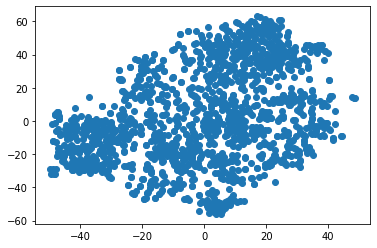

In [9]:
embeddings_use = TSNE(n_components=tsne_components, learning_rate='auto', init='random', n_jobs=-1, random_state=42).fit_transform(embeddings_use)
if embeddings_use.shape[-1] == 2:
  plt.scatter(embeddings_use[:, 0], embeddings_use[:, 1])
  plt.show()

## tfidf embedding

In [10]:
vect = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', min_df=2, max_df=1.0, binary=True)
embeddings_tfidf_binary = vect.fit_transform(test_df.sentence.to_list()).toarray()
print(embeddings_tfidf_binary.shape)

(1481, 6156)


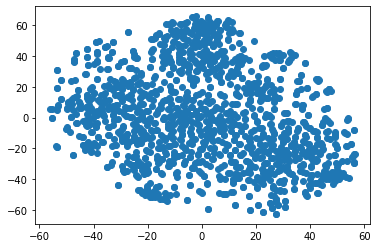

In [11]:
embeddings_tfidf_binary = TSNE(n_components=tsne_components, learning_rate='auto', init='random', n_jobs=-1, random_state=42).fit_transform(embeddings_tfidf_binary)
if embeddings_tfidf_binary.shape[-1] == 2:
  plt.scatter(embeddings_tfidf_binary[:, 0], embeddings_tfidf_binary[:, 1])
  plt.show()

## hashing embedding

In [12]:
vect = HashingVectorizer(n_features=2**13, ngram_range=(1, 2), analyzer='word')
embeddings_hash = vect.fit_transform(test_df.sentence.to_list()).toarray()
print(embeddings_hash.shape)

(1481, 8192)


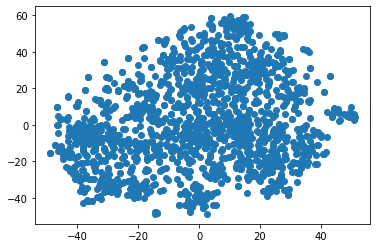

In [13]:
embeddings_hash = TSNE(n_components=tsne_components, learning_rate='auto', init='random', n_jobs=-1, random_state=42).fit_transform(embeddings_hash)
if embeddings_hash.shape[-1] == 2:
  plt.scatter(embeddings_hash[:, 0], embeddings_hash[:, 1])
  plt.show()

## Append rappresentation

In [14]:
if (embeddings_use.shape[-1] == tsne_components) and (embeddings_tfidf_binary.shape[-1] == tsne_components) and (embeddings_hash.shape[-1] == tsne_components):
  print('TSNE already done!')
  embeddings = np.concatenate([embeddings_use, embeddings_tfidf_binary, embeddings_hash], -1)
else:
  print('....perform TSNE!')
  embeddings = np.concatenate([embeddings_use, embeddings_tfidf_binary, embeddings_hash], -1)
  embeddings = TSNE(n_components=tsne_components, learning_rate='auto', init='random', n_jobs=-1, random_state=42).fit_transform(embeddings)
  if embeddings.shape[-1] == 2:
    plt.scatter(embeddings[:,0], embeddings[:,1])
plt.show()
print(embeddings.shape)

TSNE already done!
(1481, 6)


# Generating Predictions


In [15]:
true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=10, random_state=42)
preds = model.fit_predict(embeddings)

if embeddings.shape[-1] == 2:
  plt.scatter(embeddings[:,0], embeddings[:,1], c=preds)
  plt.show()

In [16]:
submission = test_df.copy()
submission['prediction'] = preds
!rm -rf assets
!mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"))
submission.head()

id                                           sentence  prediction
0  19475  sit back think thats lot layer complexity wrap...           0
1  35980  oh goodness ive run wasnt meant click thats ri...           3
2  12979  think whole world moved toward using bigger th...           8
3  40815  since think would lame post code first video g...           3
4  43475  let use new technique apply magic image goodne...           2

# Submitting our Predictions


In [17]:
%aicrowd notebook submit -c speaker-identification -a assets --no-verify

Using notebook: [Cluster] Speaker Identification.ipynb for submission...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                                      
                                                     │ Successfully submitted! │                                                      
                                                     ╰─────────────────────────╯

                                                           Important links                                                            
┌──────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xii/problems/speaker-identification/submissions/171980              │
│                  │                                                                                                                 │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-xii/problems/speaker-identification/submissions?my_submissions=true │
│                  │                                                                                                                 │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-xii/problems/speaker-identification/leaderboards                    │
│                  │                                                                                                                 │
│ Discussion forum │ https://discourse.aicrowd.com/c/ai-blitz-xii                                                                    │
│                  │                                                                                                                 │
│   Challenge page │ https://www.aicrowd.com/challenges/ai-blitz-xii/problems/speaker-identification                                 │
└──────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘